# BiSeNet
Instalación de la librería fast.ai (a continuación reiniciar el entorno de ejecución).

In [ ]:
!pip install fastai --upgrade

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from fastai.learner import defaults, Learner

from pathlib import Path
import random

Descarga de la librería de arquitecturas.

In [ ]:
!wget https://www.dropbox.com/s/cmoblvx5icdifwl/architectures.zip?dl=1 -O architectures.zip
!unzip architectures.zip

Descarga del dataset.

In [ ]:
!wget https://www.dropbox.com/s/p92cw15pleunmqe/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Conexión con Drive para el almacenaje de los modelos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Rutas a los directorios del dataset.

In [2]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

Función que dada la ruta de una imagen devuelve el path de su anotación.

In [3]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

Clases: Background y Stoma.

In [4]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Función que permite partir el dataset entre entrenamiento y test.

In [5]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation
Carga de la librería Albumentations.

In [6]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

Transformación que aplica a las imagenes giros horizontales, rotaciones y una operación de distorsión.

In [7]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Flip(p=0.5),
                    Rotate(p=0.40,limit=10),
                    ],p=1)

In [8]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Transformación que no aplica cambios a las imagenes.

In [9]:
transforms2=Compose([],p=1)

In [10]:
transform2Pipeline=SegmentationAlbumentationsTransform(transforms2)

Transformación que cambia todos los píxeles con valor 255 a valor 1 en las máscaras.

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloaders
DataBlock de entrenamiento con aumento de datos.

In [12]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de entrenamiento sin aumento de datos.

In [13]:
train2DB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transform2Pipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de test.

In [14]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Creación de los dataloaders.

In [15]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
train2DLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Prueba de la carga de datos.

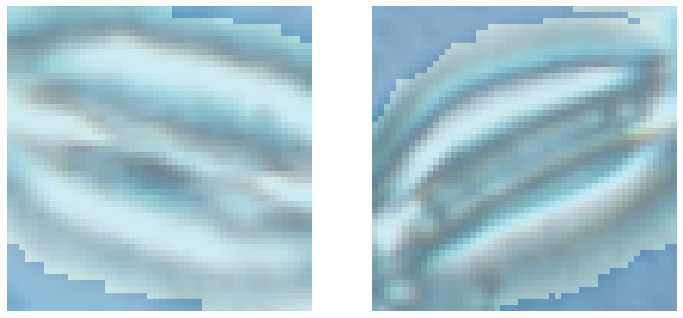

In [18]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# Modelos con aumento de datos
Definición del modelo.

In [16]:
from architectures import BiSeNet
model = BiSeNet(backbone_name="resnet18", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [17]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/BiSeNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

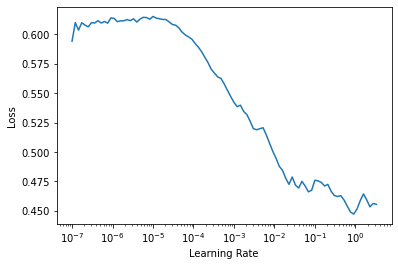

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.302849,0.482215,0.917489,0.847557,04:07
1,0.256399,0.402589,0.924298,0.859251,04:07
2,0.246629,0.361680,0.929543,0.868360,04:09
3,0.230496,0.273277,0.935936,0.879586,04:07
4,0.218016,0.223338,0.943192,0.892491,04:08
5,0.214243,0.227649,0.943805,0.893590,04:07
6,0.230630,0.211613,0.944909,0.895571,04:07
7,0.185741,0.213489,0.946446,0.898337,04:07
8,0.226916,0.207949,0.945883,0.897323,04:07
9,0.199172,0.234849,0.944163,0.894232,04:08


Better model found at epoch 0 with valid_loss value: 0.4822150468826294.


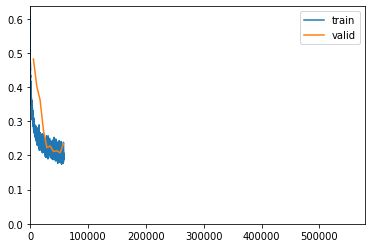

Better model found at epoch 1 with valid_loss value: 0.40258869528770447.
Better model found at epoch 2 with valid_loss value: 0.36168035864830017.
Better model found at epoch 3 with valid_loss value: 0.27327749133110046.
Better model found at epoch 4 with valid_loss value: 0.2233375757932663.
Better model found at epoch 6 with valid_loss value: 0.21161344647407532.
Better model found at epoch 8 with valid_loss value: 0.20794890820980072.
No improvement since epoch 8: early stopping


In [ ]:
name = "model_BiSeNet_resnet18_da_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_BiSeNet_resnet18_da_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.20794890820980072,0.945883222477228,0.8973229936630945]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

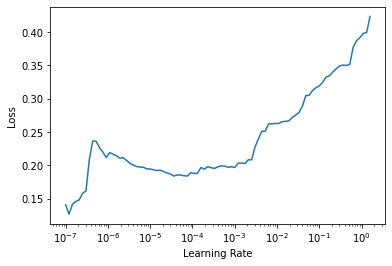

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.193276,0.203046,0.948938,0.902838,04:09
1,0.182757,0.196217,0.950087,0.904921,04:06
2,0.192445,0.199550,0.950135,0.905007,04:06
3,0.181440,0.199629,0.949462,0.903786,04:07


Better model found at epoch 0 with valid_loss value: 0.20304641127586365.


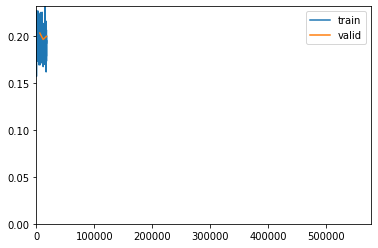

Better model found at epoch 1 with valid_loss value: 0.1962166130542755.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_BiSeNet_resnet18_da_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_BiSeNet_resnet18_da_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1962166130542755,0.9500874394677413,0.9049205383218671]



---


Definición del modelo.

In [18]:
del model, learn
model = BiSeNet(backbone_name="resnet18", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [19]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/BiSeNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

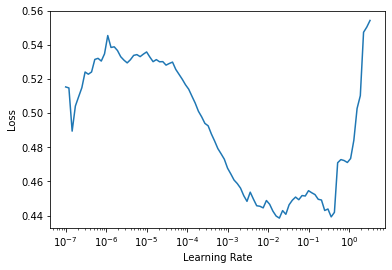

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.281507,0.435949,0.919175,0.850438,04:10
1,0.252958,0.418325,0.923752,0.858308,04:08
2,0.225851,0.391476,0.927351,0.864542,04:08
3,0.226032,0.368503,0.930757,0.870483,04:07
4,0.208441,0.253371,0.939382,0.885693,04:05
5,0.219285,0.246120,0.941342,0.889185,04:06
6,0.201741,0.222491,0.944935,0.895618,04:04
7,0.224386,0.216339,0.945872,0.897302,04:04
8,0.205129,0.202132,0.948761,0.902517,04:04
9,0.198150,0.198694,0.948611,0.902245,04:04


Better model found at epoch 0 with valid_loss value: 0.4359492063522339.


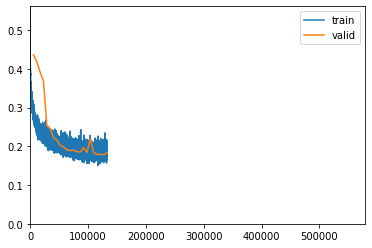

Better model found at epoch 1 with valid_loss value: 0.4183245301246643.
Better model found at epoch 2 with valid_loss value: 0.39147627353668213.
Better model found at epoch 3 with valid_loss value: 0.36850303411483765.
Better model found at epoch 4 with valid_loss value: 0.25337105989456177.
Better model found at epoch 5 with valid_loss value: 0.24612045288085938.
Better model found at epoch 6 with valid_loss value: 0.22249113023281097.
Better model found at epoch 7 with valid_loss value: 0.21633930504322052.
Better model found at epoch 8 with valid_loss value: 0.20213179290294647.
Better model found at epoch 9 with valid_loss value: 0.19869378209114075.
Better model found at epoch 10 with valid_loss value: 0.1902472972869873.
Better model found at epoch 11 with valid_loss value: 0.1895001232624054.
Better model found at epoch 13 with valid_loss value: 0.1862080842256546.
Better model found at epoch 14 with valid_loss value: 0.18520474433898926.
Better model found at epoch 16 with va

In [ ]:
name = "model_BiSeNet_resnet18_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_BiSeNet_resnet18_da_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,dice,jaccard_coeff,time


(#3) [0.17861782014369965,0.9536136956435479,0.9113400009856195]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

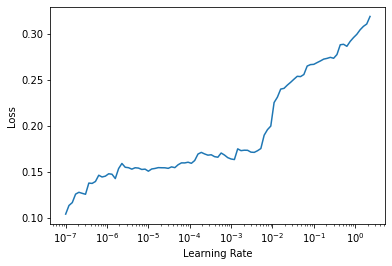

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.165247,0.171624,0.955614,0.915000,04:11
1,0.177771,0.171276,0.955496,0.914784,04:11
2,0.167002,0.169053,0.956145,0.915975,04:10
3,0.156739,0.170486,0.955870,0.915470,04:10
4,0.172854,0.168219,0.956351,0.916353,04:11
5,0.178521,0.168263,0.956386,0.916417,04:13
6,0.157635,0.173906,0.954777,0.913467,04:15


Better model found at epoch 0 with valid_loss value: 0.17162366211414337.


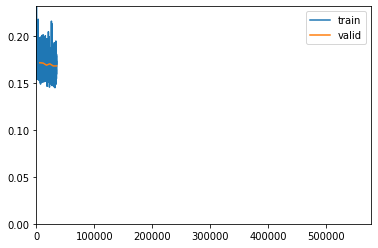

Better model found at epoch 1 with valid_loss value: 0.1712762415409088.
Better model found at epoch 2 with valid_loss value: 0.16905330121517181.
Better model found at epoch 4 with valid_loss value: 0.16821898519992828.
No improvement since epoch 4: early stopping


In [ ]:
name = "model_BiSeNet_resnet18_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_BiSeNet_resnet18_da_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.16821898519992828,0.9563509148282793,0.9163529469974311]

# Modelos sin aumento de datos
Definición del modelo.

In [ ]:
del model, learn
model = BiSeNet(backbone_name="resnet18", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/BiSeNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

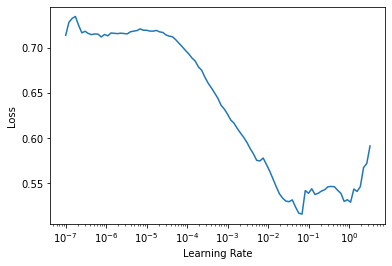

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.304923,0.402321,0.919523,0.851034,04:13
1,0.268173,0.341811,0.926042,0.862270,04:11
2,0.272191,0.305322,0.932001,0.872660,04:12
3,0.259199,0.266817,0.936297,0.880224,04:10
4,0.234868,0.245318,0.936414,0.880431,04:09
5,0.214287,0.220182,0.943443,0.892940,04:09
6,0.200595,0.224324,0.943580,0.893186,04:09
7,0.219319,0.210975,0.945379,0.896416,04:13
8,0.227098,0.195109,0.949445,0.903756,04:08
9,0.210296,0.203883,0.946668,0.898737,04:08


Better model found at epoch 0 with valid_loss value: 0.4023207426071167.


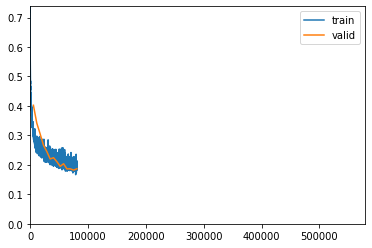

Better model found at epoch 1 with valid_loss value: 0.3418113887310028.
Better model found at epoch 2 with valid_loss value: 0.305321604013443.
Better model found at epoch 3 with valid_loss value: 0.2668169438838959.
Better model found at epoch 4 with valid_loss value: 0.245317742228508.
Better model found at epoch 5 with valid_loss value: 0.22018218040466309.
Better model found at epoch 7 with valid_loss value: 0.21097469329833984.
Better model found at epoch 8 with valid_loss value: 0.19510892033576965.
Better model found at epoch 10 with valid_loss value: 0.18636690080165863.
Better model found at epoch 12 with valid_loss value: 0.18230599164962769.
No improvement since epoch 12: early stopping


In [ ]:
name = "model_BiSeNet_resnet18_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_BiSeNet_resnet18_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.18230599164962769,0.9524740209167503,0.9092605242595654]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

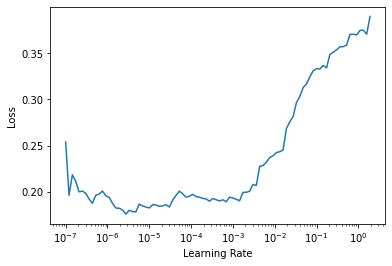

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.194580,0.179833,0.953469,0.911076,04:08
1,0.183964,0.181532,0.952844,0.909935,04:07
2,0.196867,0.177506,0.954028,0.912097,04:08
3,0.191209,0.179803,0.953386,0.910925,04:10
4,0.182179,0.177461,0.954166,0.912349,04:07


Better model found at epoch 0 with valid_loss value: 0.17983287572860718.


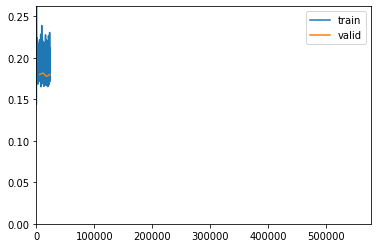

Better model found at epoch 2 with valid_loss value: 0.1775064915418625.
No improvement since epoch 2: early stopping


In [ ]:
name = "model_BiSeNet_resnet18_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_BiSeNet_resnet18_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1775064915418625,0.9540276885042446,0.9120965039122033]



---


Definición del modelo.

In [ ]:
del model, learn
model = BiSeNet(backbone_name="resnet18", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/BiSeNet"

Freeze y elección de la tasa de aprendizaje.

Recorder

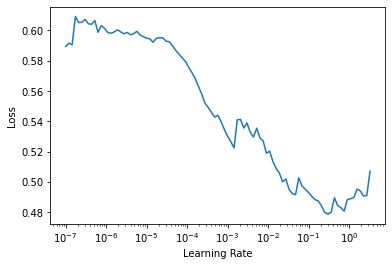

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.281666,0.434133,0.919492,0.850982,04:11
1,0.270016,0.396502,0.924814,0.860143,04:10
2,0.236430,0.333343,0.930302,0.869687,04:11
3,0.246822,0.316457,0.934034,0.876232,04:11
4,0.221241,0.237289,0.942085,0.890511,04:10
5,0.226681,0.236338,0.942293,0.890884,04:12
6,0.245258,0.231291,0.942413,0.891098,04:13
7,0.221650,0.205365,0.947392,0.900043,04:13
8,0.215698,0.202364,0.948287,0.901659,04:13
9,0.209135,0.205323,0.946998,0.899331,04:13


Better model found at epoch 0 with valid_loss value: 0.4341326951980591.


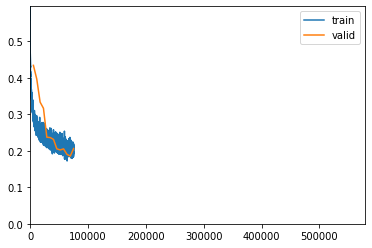

Better model found at epoch 1 with valid_loss value: 0.39650169014930725.
Better model found at epoch 2 with valid_loss value: 0.3333434760570526.
Better model found at epoch 3 with valid_loss value: 0.3164568841457367.
Better model found at epoch 4 with valid_loss value: 0.23728901147842407.
Better model found at epoch 5 with valid_loss value: 0.2363380640745163.
Better model found at epoch 6 with valid_loss value: 0.2312909960746765.
Better model found at epoch 7 with valid_loss value: 0.20536525547504425.
Better model found at epoch 8 with valid_loss value: 0.20236381888389587.
Better model found at epoch 10 with valid_loss value: 0.19055262207984924.
Better model found at epoch 11 with valid_loss value: 0.18541346490383148.
No improvement since epoch 11: early stopping


In [ ]:
name = "model_BiSeNet_resnet18_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_BiSeNet_resnet18_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.18541346490383148,0.9516860168932529,0.9078253578883582]

Unfreeze y elección de la tasa de aprendizaje.

Recorder

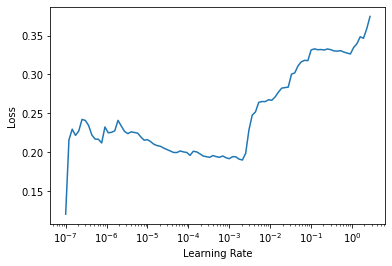

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.194406,0.180518,0.953087,0.910379,04:11
1,0.188261,0.188985,0.951439,0.907376,04:11
2,0.187615,0.183473,0.952374,0.909079,04:13


Better model found at epoch 0 with valid_loss value: 0.1805180162191391.


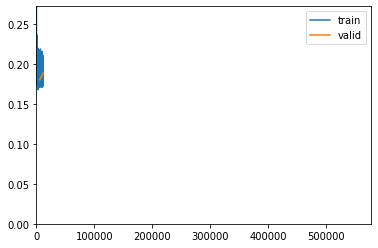

No improvement since epoch 0: early stopping


In [ ]:
name = "model_BiSeNet_resnet18_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_BiSeNet_resnet18_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1805180162191391,0.9530870844658748,0.9103785714398398]

# Evaluación de resultados
## Modelos con aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_BiSeNet_resnet18_da_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.18772974610328674,0.9532054775487498,0.9105946363921112]

Comparación de resultado buscado contra resultado obtenido.

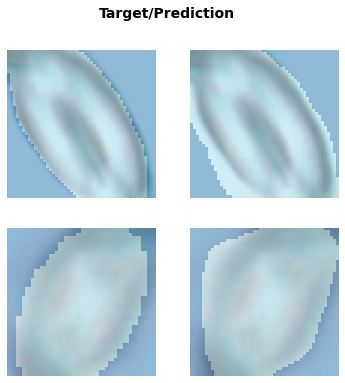

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_BiSeNet_resnet18_da_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.17860783636569977,0.9552781414843046,0.9143851386832573]

Comparación de resultado buscado contra resultado obtenido.

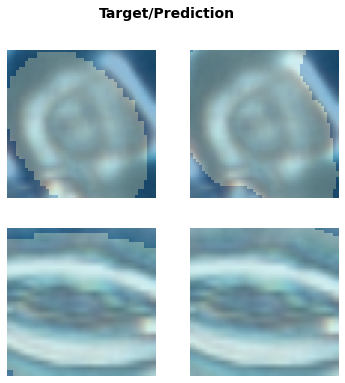

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_BiSeNet_resnet18_da_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16481821238994598,0.9577030256361542,0.9188389194170666]

Comparación de resultado buscado contra resultado obtenido.

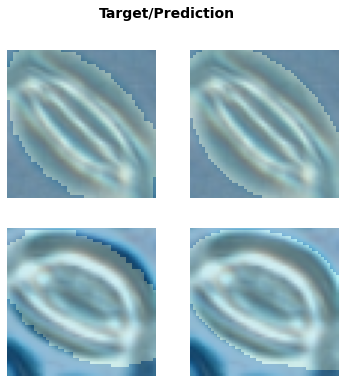

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_BiSeNet_resnet18_da_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.1568794846534729,0.9597625102875217,0.922637878156843]

Comparación de resultado buscado contra resultado obtenido.

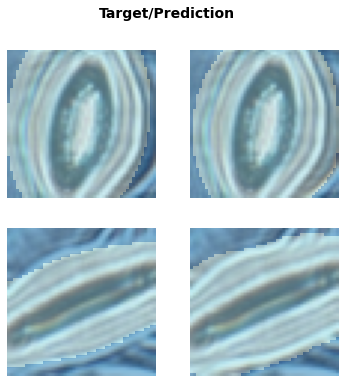

In [33]:
learn.show_results(vmin=0,vmax=1)

## Modelos sin aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_BiSeNet_resnet18_wd2")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16901732981204987,0.9567316599664318,0.9170523280095398]

Comparación de resultado buscado contra resultado obtenido.

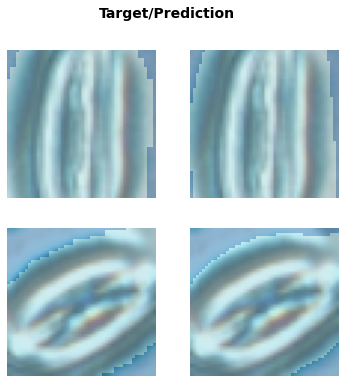

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_BiSeNet_resnet18_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16495849192142487,0.957959215970111,0.9193106744492198]

Comparación de resultado buscado contra resultado obtenido.

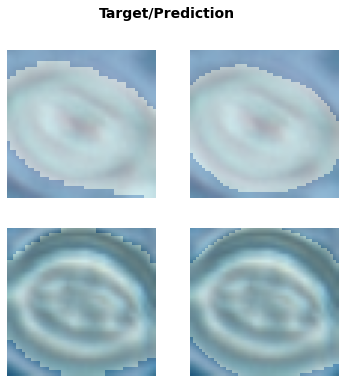

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_BiSeNet_resnet18_wd1")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.17064839601516724,0.9562333661878143,0.9161371279855243]

Comparación de resultado buscado contra resultado obtenido.

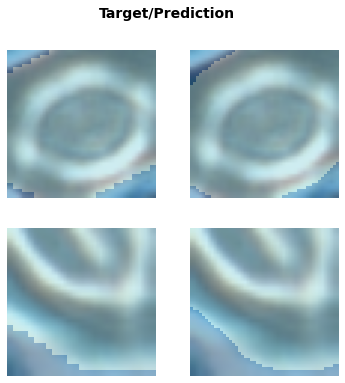

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_BiSeNet_resnet18_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

(#3) [0.16628359258174896,0.9575378444400785,0.9185348737439502]

Comparación de resultado buscado contra resultado obtenido.

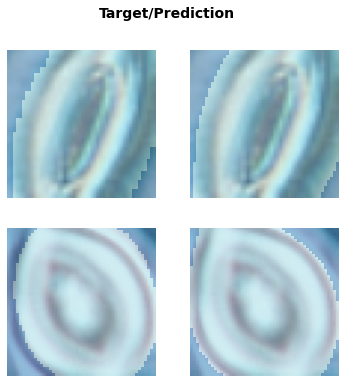

In [ ]:
learn.show_results(vmin=0,vmax=1)

# Exportación del mejor modelo
Carga del modelo en la CPU.

In [20]:
learn.load("model_BiSeNet_resnet18_da_wd1_unfreeze")
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.1568797379732132,0.9597625102875217,0.922637878156843]

In [21]:
aux=learn.model
aux=aux.cpu()

Exportación del modelo mediante torch.jit.trace.

In [22]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/1D2_0.png')
transformer=transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("/content/drive/MyDrive/Colab Notebooks/BiSeNet/model_BiSeNet_resnet18.pkl")